In [2]:
from time import time
import pandas as pd
import dask.dataframe as dd
from ord_data_load import draw_reaction_rand, draw_reaction_solvents
from rdkit.Chem import CanonSmiles
import numpy as np
import re
import colorama

#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

ORD_PATH = 'C:/Users/ergot/PycharmProjects/chem/ORD'

%load_ext autoreload
%autoreload 2

In [3]:
%%time
all_reactions = pd.read_pickle(f"{ORD_PATH}/all_reactions.pkl")

CPU times: total: 19.2 s
Wall time: 21.3 s


In [20]:
all_reactions.sample(n=10000)['notes'].to_csv('rxn_notes.txt', index=False)
# all_reactions['notes'].to_csv('rxn_notes.txt', index=False)

In [3]:
# create new solvent field
all_reactions['SOLV'] = np.nan

In [4]:
%%time
all_reactions['solvent count'] = all_reactions['solvents'].apply(lambda x: len(x))

CPU times: total: 750 ms
Wall time: 750 ms


In [5]:
(all_reactions['solvent count'].value_counts() / len(all_reactions))

1     4.802229e-01
0     2.260690e-01
2     1.986758e-01
3     6.250489e-02
4     1.913864e-02
5     7.810527e-03
7     3.723156e-03
6     1.568585e-03
8     1.793148e-04
9     6.535772e-05
10    1.731700e-05
11    1.228949e-05
14    3.910291e-06
12    3.351678e-06
15    3.351678e-06
19    5.586130e-07
13    5.586130e-07
16    5.586130e-07
Name: solvent count, dtype: float64

# Single solvent

## solvents with no smiles

In [50]:
%%time
def is_none_smiles(solvents: list):
    if not solvents:
        return None
    for (solvent_name, solvent_smile) in solvents:
        if solvent_smile is None:
            return solvent_name
    return None

none_smiles = all_reactions['solvents'].apply(is_none_smiles)
none_smiles.value_counts()

CPU times: total: 469 ms
Wall time: 471 ms


hexanes                      5062
ice water                    3095
petroleum ether              1461
solution                      980
ice                           722
                             ... 
2/1/1                           1
1/1.5                           1
KPO4                            1
Mg                              1
boron trifluoride-diethyl       1
Name: solvents, Length: 1526, dtype: int64

Reaction: 79


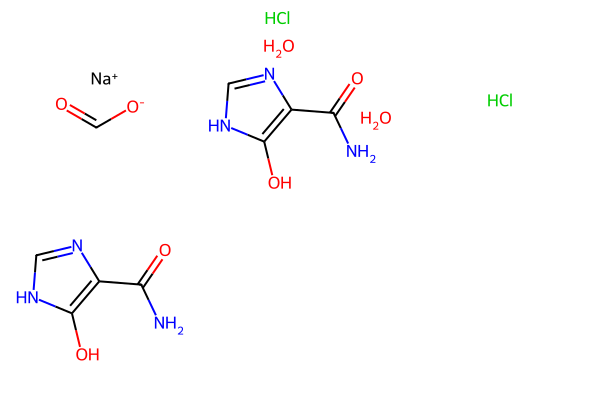

Under the nitrogen atmosphere, 20.0 g of 5-hydroxy-1H-imidazole-4-carboxamide hydrochloric acid salt dihydrate prepared according to the method of Reference Example 2 was added to 240 mL of 0.45 mol/L hydrochloric acid and dissolved therein by heating to 50° C. At 50° C., 40 mL aqueous solution containing 14.3 g of sodium formate was added dropwise thereto over 35 minutes. The reaction mixture was cooled and stirred for 90 minutes with the inside temperature of 5° C. The crystal was collected by filtration and then washed with a mixture liquid containing 20 mL of acetone and 40 mL of water followed by 60 mL of acetone to give 12.6 g of 5-hydroxy-1H-imidazole-4-carboxamide.3/4 hydrate as a pale yellow crystal.


In [202]:
draw_reaction_rand(all_reactions.loc[none_smiles == 'aqueous solution'], notes_text='solution')

Reaction: 369747


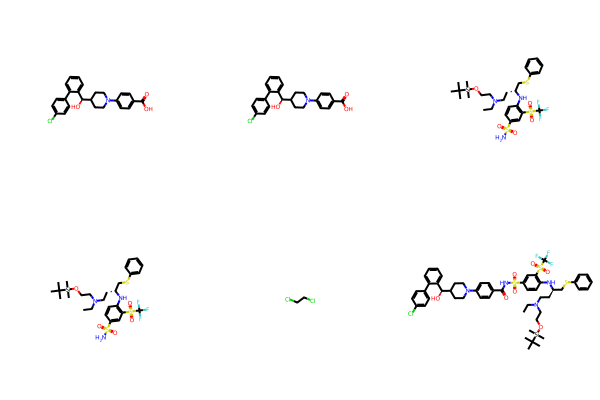

(R)-4-(4-((4′-chlorobiphenyl-2-yl)(hydroxy)methyl)piperidin-1-yl)benzoic acid (INTERMEDIATE 40, 2.15 g, 5.10 mmol), (R)-4-(4-((2-(tert-butyldimethylsilyloxy)ethyl)(ethyl)amino)-1-(phenylthio)butan-2-ylamino)-3-(trifluoromethylsulfonyl)benzenesulfonamide (INTERMEDIATE 65, 3.41 g, 5.10 mmol), DMAP (1.87 g, 15.29 mmol) and EDC (1.954 g, 10.19 mmol) were dissolved in DCM (17 ml). The reaction mixture was stirred at r.t. overnight, diluted with DCM (50 ml) and washed with NH4Cl solution (saturated, aq., 20 ml), saturated aq. NaHCO3 (20 ml) and brine (20 ml). The collected organic layer was dried over Na2SO4 and concentrated under reduced pressure. The concentrate was purified by column chromatography (ISCO, 12 g silica gel, eluted with 0→20% MeOH in EtOAc) to provide the title compound (3.41 g, yield: 62%).
CPU times: total: 297 ms
Wall time: 301 ms


In [203]:
%%time
draw_reaction_rand(all_reactions.loc[all_reactions['solvent count'] > 1])

In [242]:
multi_solvent = all_reactions.loc[all_reactions['solvent count'] > 1]

In [1]:
draw_reaction_solvents(multi_solvent)

NameError: name 'draw_reaction_solvents' is not defined

### ice water
```ice water``` is almost always mistakenly attributed as a solvent, while it is part of workup or cooling bath. We can safely remove it from ```solvents``` field

In [148]:
%%time

solvent_names = []
solvent_smiles = []


for solvents in all_reactions['solvents']:
    for (name, smiles) in solvents:
        solvent_names.append(str(name))
        solvent_smiles.append(CanonSmiles(smiles) if smiles else None)

df_solvents = pd.DataFrame({'names': solvent_names, 'smiles': solvent_smiles})
name_counts = dict(df_solvents.groupby('names')['smiles'].apply(len))

df_solvents = df_solvents.groupby('smiles').apply(lambda db: pd.Series({'names': tuple(set(sorted(db['names']))), 'count': len(db)})).sort_values('count', ascending=False)
df_solvents['count'] /= len(all_reactions)

df_solvents.reset_index(inplace=True)

CPU times: total: 2min 49s
Wall time: 2min 49s


In [149]:
df_solvents

,smiles,names,count
0,C1CCOC1,"(THF, tetrahydrofurane, tetrahydrofuran-, Tetr...",1.616933e-01
1,O,"(None, H−OH, Water, water-, WATER, water, DI w...",1.478705e-01
2,ClCCl,"(Methylene chloride, methylene cloride, METHYL...",1.467443e-01
3,CN(C)C=O,"(dimethylformamid, N,N-di-methyl-formamide, N,...",1.099563e-01
4,CO,"(Metanol, Methanol, None, methly alcohol, meth...",8.391597e-02
...,...,...,...
2591,COC(=O)c1c(CS(=O)(=O)c2ccccc2)ccc2c1OCc1occc1-2,"(methyl 7-(benzenesulfonylmethyl)-4H-furo[2,3-...",5.586130e-07
2592,COC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@...,"(H-Leu-Leu-Pro-OMe,)",5.586130e-07
2593,COC(=O)N1CCC(Oc2cc(S(=O)(=O)Nc3cc(C)ccc3OC)cc3...,(methyl 4-[(5-{[(2-methoxy-5-methylphenyl)amin...,5.586130e-07
2594,COC(=O)Cl,"(methyl chloroformate,)",5.586130e-07
